# Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
## Research Paper Link : https://arxiv.org/pdf/2103.14030
## Github Link : https://github.com/yogeshbawankar/PyTorch-Collection

Loading CIFAR-10...


100%|██████████| 170M/170M [10:45<00:00, 264kB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training...
Epoch 1/5 | Loss: 1.9595 | Acc: 25.41%
Epoch 2/5 | Loss: 1.8756 | Acc: 28.73%
Epoch 3/5 | Loss: 1.9054 | Acc: 27.33%
Epoch 4/5 | Loss: 2.0433 | Acc: 21.97%
Epoch 5/5 | Loss: 1.9827 | Acc: 24.78%
Test Accuracy: 25.92%


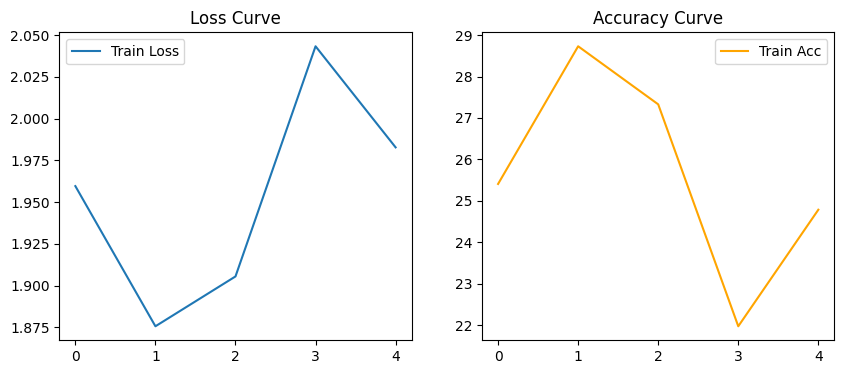

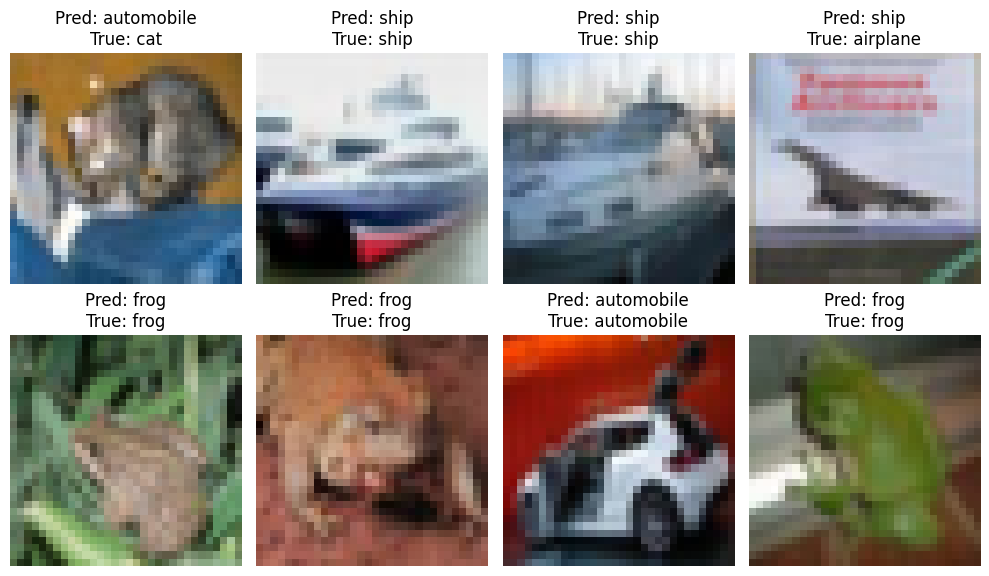

In [1]:
# ----------------------------------------------------------
# Mini-Swin: A Didactic Replication of the Swin Transformer
# Inspired by "Swin Transformer: Hierarchical Vision Transformer
# using Shifted Windows" (Liu et al., 2021)
# ----------------------------------------------------------
# This script trains a simplified Swin Transformer on CIFAR-10,
# including hierarchical stages, shifted windows, and patch merging.
# End-to-end: dataset → model → training → evaluation → predictions.
# ----------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# 1. Dataset (CIFAR-10)
# ==========================================================
print("Loading CIFAR-10...")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

classes = train_dataset.classes
print("Classes:", classes)

# ==========================================================
# 2. Swin Transformer Components
# ==========================================================

# Patch embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, embed_dim=96, patch_size=4):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)   # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

# Partition into windows
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size*window_size, C)
    return windows

# Merge windows back
def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0,1,3,2,4,5).contiguous().view(B, H, W, -1)
    return x

# Window-based attention
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        out, _ = self.attn(x, x, x)
        return out

# Swin Block (with optional shifting)
class SwinBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=4, shift=False, mlp_ratio=4.):
        super().__init__()
        self.shift = shift
        self.window_size = window_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim*mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim*mlp_ratio), dim)
        )

    def forward(self, x, H, W):
        B, L, C = x.shape
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # shift if needed
        if self.shift:
            s = self.window_size // 2
            x = torch.roll(x, shifts=(-s, -s), dims=(1,2))

        windows = window_partition(x, self.window_size)
        out = self.attn(windows)
        x = window_reverse(out, self.window_size, H, W)

        # reverse shift
        if self.shift:
            s = self.window_size // 2
            x = torch.roll(x, shifts=(s, s), dims=(1,2))

        x = x.view(B, H*W, C)
        x = x + self.mlp(self.norm2(x))  # residual
        return x

# Patch merging: downsample 2x, double channels
class PatchMerging(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.reduction = nn.Linear(4*input_dim, 2*input_dim, bias=False)

    def forward(self, x, H, W):
        B, L, C = x.shape
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)
        x = x.view(B, -1, 4*C)
        x = self.reduction(x)
        return x

# Full Mini-Swin (2 stages for CIFAR-10)
class MiniSwin(nn.Module):
    def __init__(self, num_classes=10, img_size=32, patch_size=4, embed_dim=96):
        super().__init__()
        self.patch_embed = PatchEmbedding(3, embed_dim, patch_size)
        H = W = img_size // patch_size

        # Stage 1
        self.stage1 = nn.ModuleList([
            SwinBlock(embed_dim, num_heads=3, window_size=4, shift=False),
            SwinBlock(embed_dim, num_heads=3, window_size=4, shift=True)
        ])

        # Merge + Stage 2
        self.merge1 = PatchMerging(embed_dim)
        self.stage2 = nn.ModuleList([
            SwinBlock(embed_dim*2, num_heads=6, window_size=2, shift=False),
            SwinBlock(embed_dim*2, num_heads=6, window_size=2, shift=True)
        ])

        # Classifier
        self.norm = nn.LayerNorm(embed_dim*2)
        self.fc = nn.Linear(embed_dim*2, num_classes)

        self.H = H
        self.W = W

    def forward(self, x):
        x = self.patch_embed(x)  # (B, N, C)
        H, W = self.H, self.W

        for blk in self.stage1:
            x = blk(x, H, W)

        x = self.merge1(x, H, W)
        H, W = H//2, W//2

        for blk in self.stage2:
            x = blk(x, H, W)

        x = self.norm(x)
        x = x.mean(dim=1)   # global pooling
        x = self.fc(x)
        return x

# ==========================================================
# 3. Training
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniSwin(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 5
train_loss, train_acc = [], []

print("Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.*correct/total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

# ==========================================================
# 4. Evaluation
# ==========================================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

print(f"Test Accuracy: {100.*correct/total:.2f}%")

# ==========================================================
# 5. Visualizations
# ==========================================================
# Training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss"); plt.legend(); plt.title("Loss Curve")
plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Acc", color="orange"); plt.legend(); plt.title("Accuracy Curve")
plt.show()

# Predictions on test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = outputs.max(1)

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,6))
for idx in range(8):
    plt.subplot(2,4,idx+1)
    imshow(images[idx].cpu(), f"Pred: {classes[predicted[idx]]}\nTrue: {classes[labels[idx]]}")
plt.tight_layout()
plt.show()
